<a href="https://colab.research.google.com/github/r-kovalch/acter-ner/blob/main/notebooks/acter-cvalue-rerank-annotation-plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/r-kovalch/acter-ner

Cloning into 'acter-ner'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 538 (delta 20), reused 8 (delta 5), pack-reused 491 (from 1)
Receiving objects: 100% (538/538), 4.27 MiB | 19.20 MiB/s, done.
Resolving deltas: 100% (346/346), done.


In [3]:
!git clone https://github.com/lang-uk/extractomat.git

Cloning into 'extractomat'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 43 (delta 19), reused 35 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 49.77 KiB | 16.59 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [4]:
!git clone https://github.com/AylaRT/ACTER

Cloning into 'ACTER'...
remote: Enumerating objects: 5448, done.
remote: Counting objects: 100% (5448/5448), done.
remote: Compressing objects: 100% (3304/3304), done.
remote: Total 5448 (delta 2684), reused 4893 (delta 2132), pack-reused 0 (from 0)
Receiving objects: 100% (5448/5448), 11.90 MiB | 15.72 MiB/s, done.
Resolving deltas: 100% (2684/2684), done.


In [1]:
!pip install -q \
  numpy==1.26.4 \
  spacy \
  spacy-layout \
  sentence-transformers \
  gitpython \
  matplotlib \
  tqdm -q

!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 137.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import subprocess, sys
from pathlib import Path

In [95]:
root_folder = "content"

# val
GT_CSV = Path("val_full/gt_labels.csv")
# text to label
UNLABELED_TXT = Path("train_full/text.txt")
NLP_MODEL = "en_core_web_sm"

OUTPUT_DIR = "/content/drive/MyDrive/ucu/ner/threshold_datasets"

C_VALUE_N_MIN = 2
C_VALUE_N_MAX = 8

RERANK_CONTEXT_LEN = 3
RERANK_POOLING = "max"

TERM_EVALUATOR_LANG = "en"

SENTENCE_SIMILARITY_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"

cvalue_rerank_thresholds = {
    "C-Value": {"min": 1.0, "mean": 0.75, "max": 2},
    "ReRank":  {"min": 0.2, "mean": 0.275, "max": 0.3}
}

test_size = 0.0
val_size = 0.2
seed = 42

In [81]:
# IOB directories inside the cloned ACTER repository
io_dirs = [
    f"/{root_folder}/ACTER/en/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    f"/{root_folder}/ACTER/en/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    f"/{root_folder}/ACTER/en/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    f"/{root_folder}/ACTER/en/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
]

train_tsv = Path("train_full.tsv")
val_tsv   = Path("val_full.tsv")
test_tsv  = Path("dummy_test.tsv")

args = [
    "python", f"/{root_folder}/acter-ner/term_extractor/preprocess_acter.py",
    "--input_dirs", *io_dirs,
    "--train_output", str(train_tsv),
    "--test_output",  str(test_tsv),
    "--val_output",   str(val_tsv),
    "--test_size", str(test_size),            # no test set – everything goes to val
    "--val_size",  str(val_size),
    "--seed",      "42",
]

print("⏳ Running:", " ".join(args))
subprocess.check_call(args)
print("✓ Splits ready →", train_tsv, ",", test_tsv , "and", val_tsv)


⏳ Running: python /content/acter-ner/term_extractor/preprocess_acter.py --input_dirs /content/ACTER/en/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ /content/ACTER/en/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ /content/ACTER/en/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ /content/ACTER/en/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ --train_output train_full.tsv --test_output dummy_test.tsv --val_output val_full.tsv --test_size 0.0 --val_size 0.2 --seed 42
✓ Splits ready → train_full.tsv , dummy_test.tsv and val_full.tsv


In [82]:
from pathlib import Path
import spacy

from extractomat.matcha import cvalue

nlp = spacy.load(NLP_MODEL, disable=["ner"])
nlp.max_length = 1500000

doc = nlp(UNLABELED_TXT.read_text().lower())
term_scores, term_occ = cvalue(
    doc,
    n_min=C_VALUE_N_MIN,
    n_max=C_VALUE_N_MAX,
    smoothing=0.1
)

print(f"Extracted {len(term_scores):,} candidate terms")

Extracted 24,720 candidate terms


In [83]:
sys.path.insert(0, str(Path.cwd() / "extractomat"))

In [84]:
import numpy as np
from tester import TermEvaluator

evaluator = TermEvaluator(
    GT_CSV,
    term_scores,          # from Cell 5
    term_occ,             # from Cell 5
    method="cvalue",
    language=TERM_EVALUATOR_LANG
)

scores = np.array(list(term_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

best = {"f1": -1.0}

for t in thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        # no candidates or no GT terms at this t → skip
        continue
    if f1 > best["f1"]:
        best.update(threshold=t, precision=p, recall=r, f1=f1)


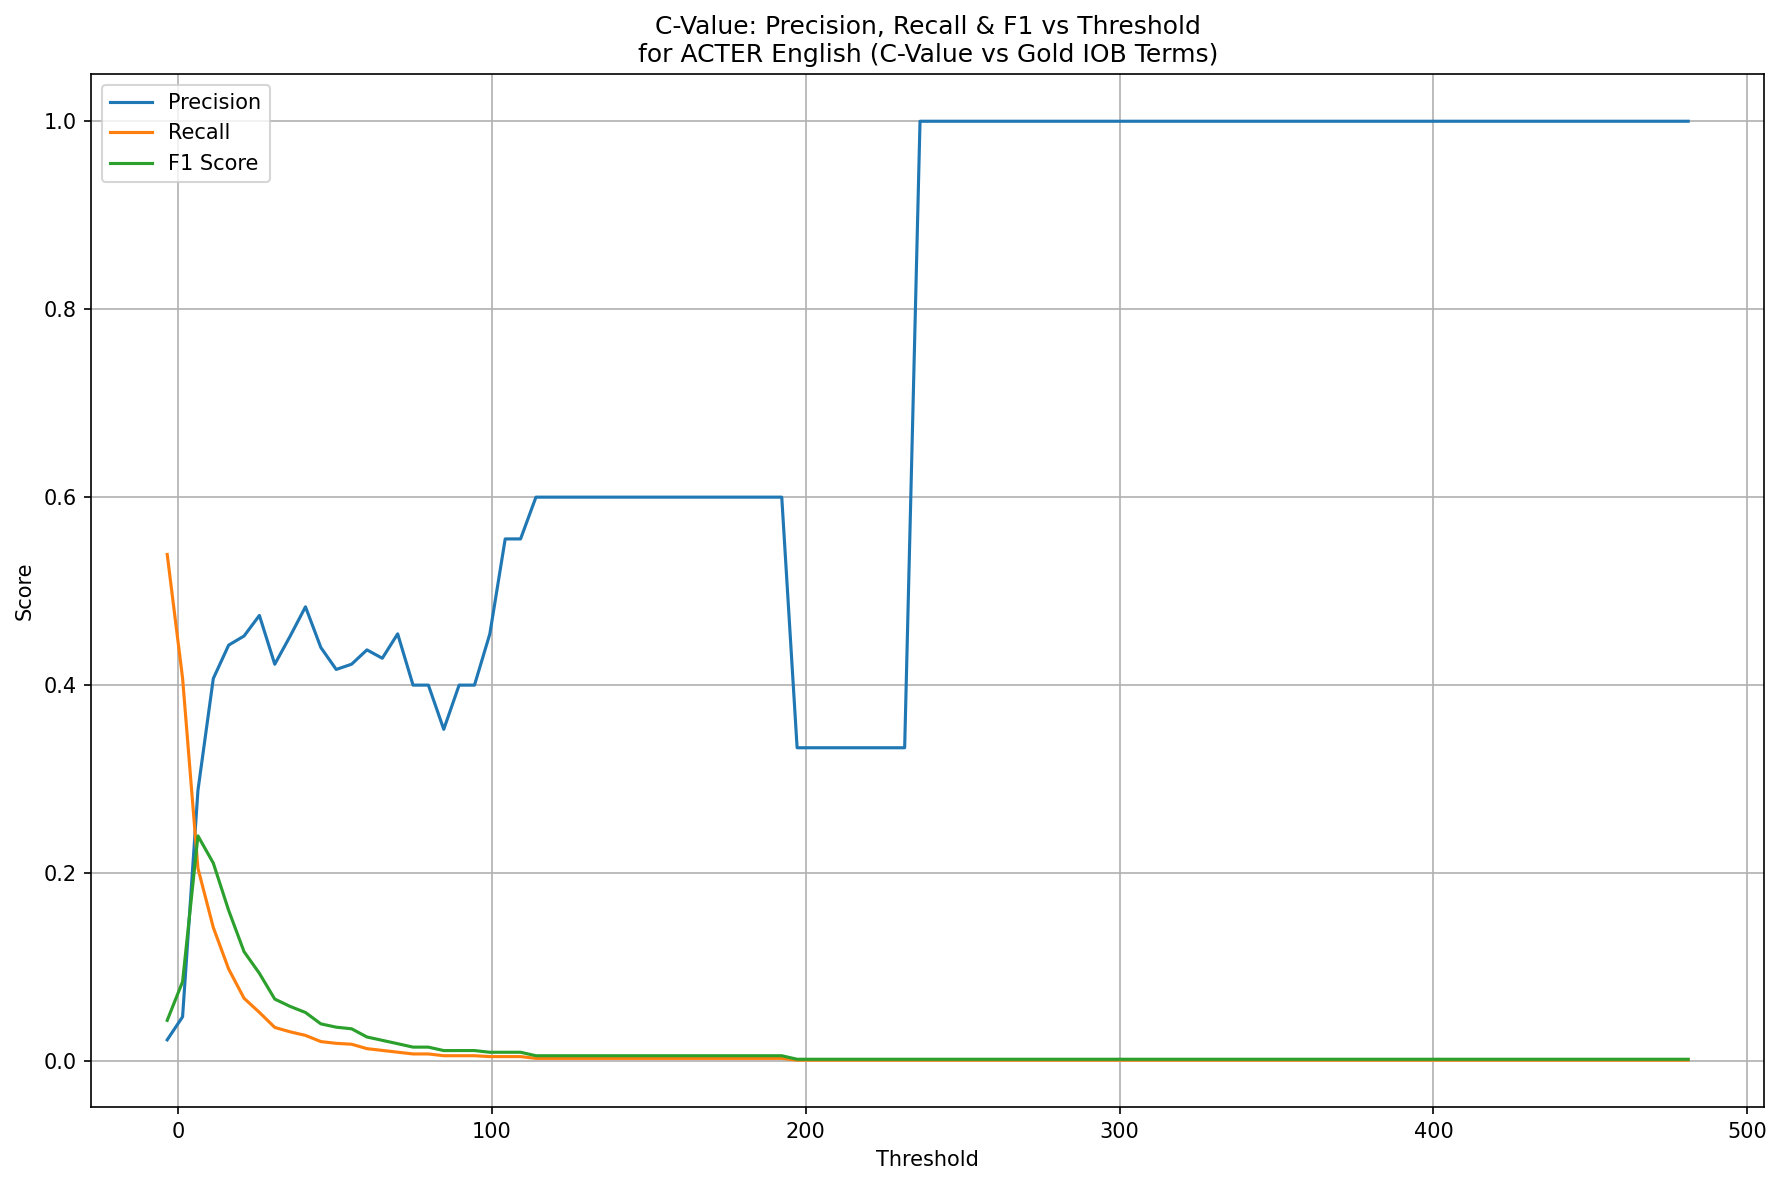

▶ Best C-Value results (threshold sweep):
   threshold = 6.39937
   precision = 0.288
   recall    = 0.205
   F1        = 0.240


In [86]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
from pathlib import Path

scores = np.array(list(term_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

precisions, recalls, f1_scores = [], [], []
for t in thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        p = r = f1 = 0.0
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# ── plotting ──────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls,    label="Recall")
plt.plot(thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("C-Value: Precision, Recall & F1 vs Threshold\nfor ACTER English (C-Value vs Gold IOB Terms)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("▶ Best C-Value results (threshold sweep):")
print(f"   threshold = {best['threshold']:.5f}")
print(f"   precision = {best['precision']:.3f}")
print(f"   recall    = {best['recall']:.3f}")
print(f"   F1        = {best['f1']:.3f}")



In [87]:
import sys, os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sbert_reranker import SentenceSimilarityCalculator

# ── load torch & SBERT (GPU if available) ─────────────────────────────────
import torch
from sentence_transformers import SentenceTransformer  # imported for completeness

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 SBERT device → {device}")

# ── instantiate the reranker correctly ────────────────────────────────────
reranker = SentenceSimilarityCalculator(
    model_name=SENTENCE_SIMILARITY_MODEL,
    device=device
)

# ── re-rank your C-Value candidates ───────────────────────────────────────
reranked_scores = reranker.rerank_terms_in_doc(
    doc,             # spaCy Doc from C-Value step
    term_occ,        # occurrences dict from C-Value step
    context_len=RERANK_CONTEXT_LEN,
    pooling=RERANK_POOLING
)
print(f"✅ Re-ranked {len(reranked_scores):,} terms")

🔧 SBERT device → cuda
✅ Re-ranked 24,720 terms


In [88]:
import pandas as pd

gt_labels_df = pd.read_csv(GT_CSV, header=None)

gt_terms = set(gt_labels_df[0].to_list())

print(f"🎯 Loaded {len(gt_terms):,} gold terms")

🎯 Loaded 2,357 gold terms


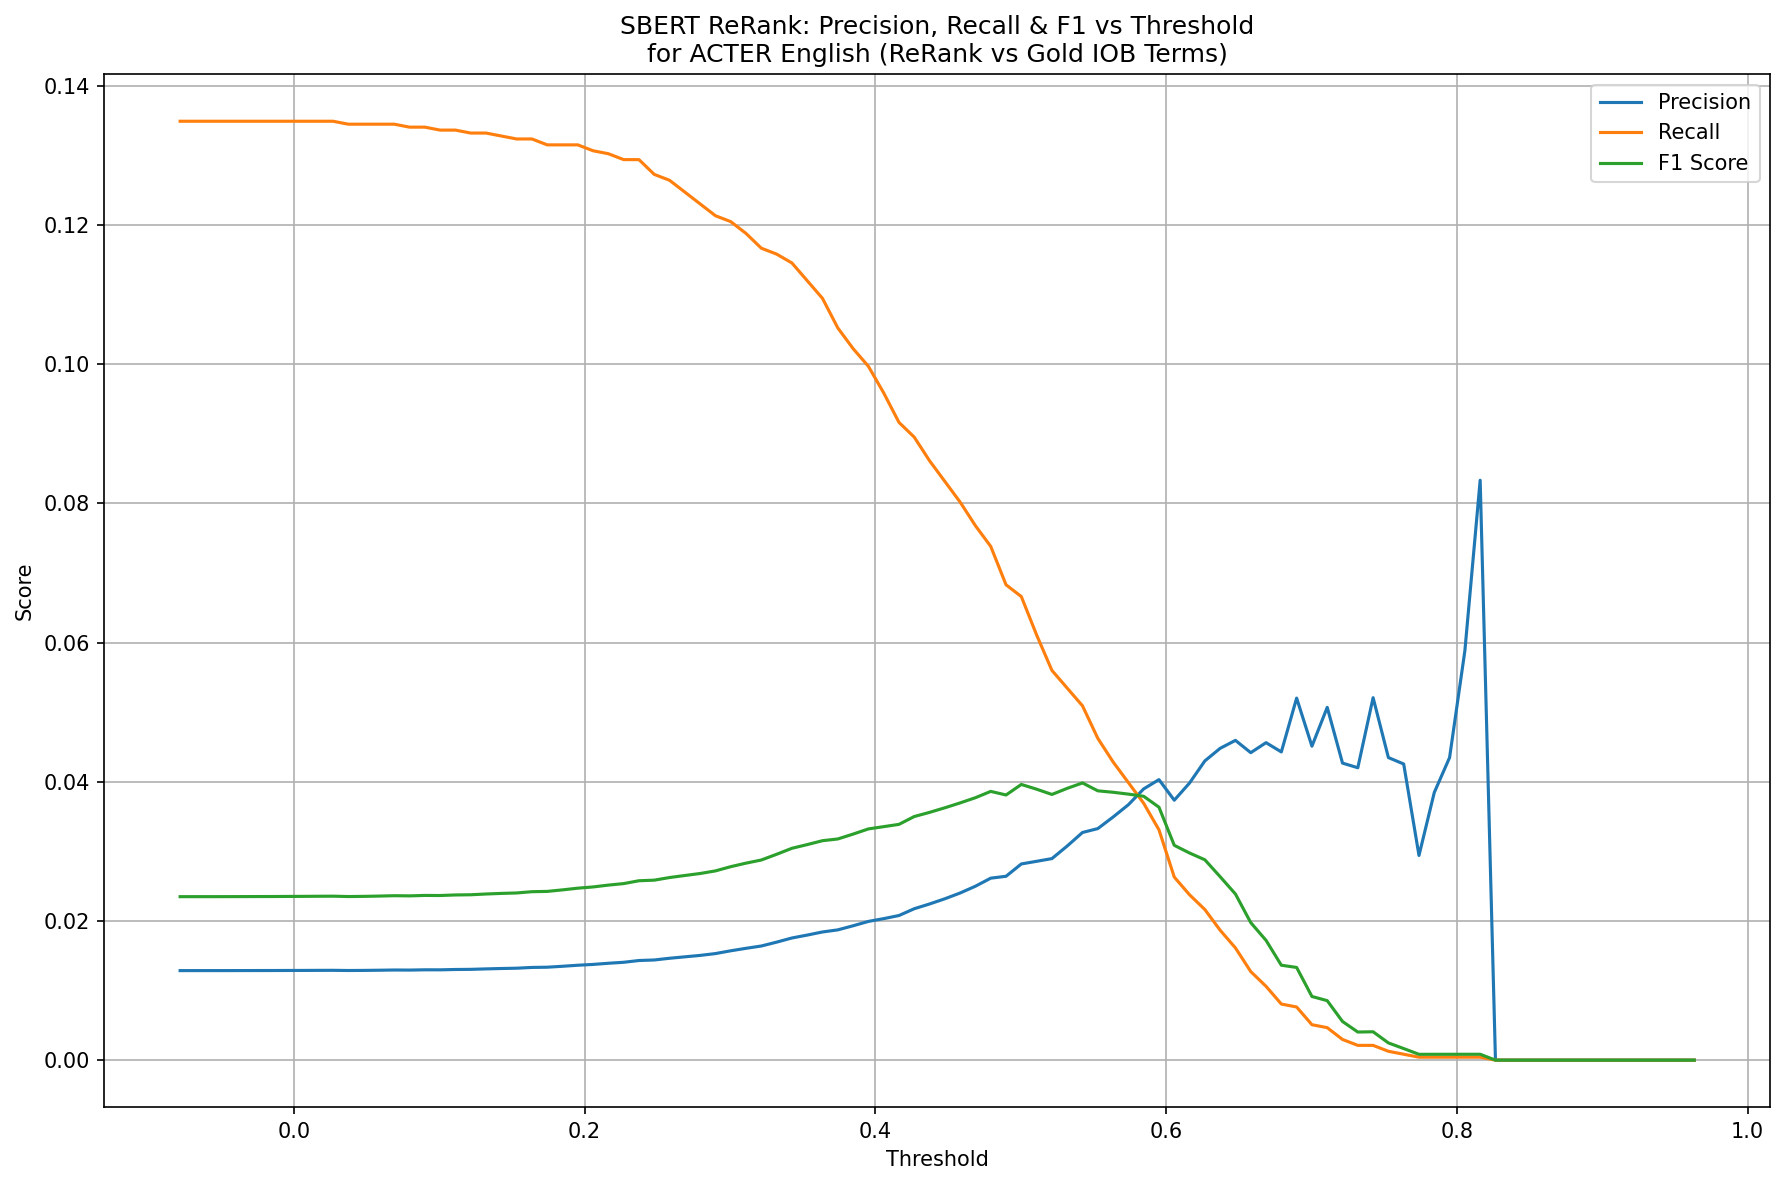

▶ Best ReRanked Results:
   threshold = 0.71084
   precision = 0.009
   recall    = 0.019
   F1        = 0.012


In [89]:
scores = np.array(list(reranked_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

precisions, recalls, f1_scores = [], [], []
for t in thresholds:
    preds = {term for term, sc in reranked_scores.items() if sc >= t}
    tp = len(preds & gt_terms)
    p = tp / len(preds) if preds else 0.0
    r = tp / len(gt_terms) if gt_terms else 0.0
    f1 = (2 * p * r / (p + r)) if (p + r) > 0 else 0.0
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# ── plot Precision, Recall & F1 vs Threshold ─────────────────────────────
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls,    label="Recall")
plt.plot(thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title(
    "SBERT ReRank: Precision, Recall & F1 vs Threshold\n"
    "for ACTER English (ReRank vs Gold IOB Terms)"
)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
scores_arr = np.array(list(reranked_scores.values()))
t_min, t_max = scores_arr.min(), scores_arr.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

best = {"f1": -1.0}
for t in thresholds:
    preds = {term for term, sc in reranked_scores.items() if sc >= t}
    tp = len(preds & gold_terms)
    p = tp / len(preds) if preds else 0.0
    r = tp / len(gold_terms) if gold_terms else 0.0
    f1 = (2 * p * r / (p + r)) if (p + r) > 0 else 0.0
    if f1 > best["f1"]:
        best.update(threshold=t, precision=p, recall=r, f1=f1)

print("▶ Best ReRanked Results:")
print(f"   threshold = {best['threshold']:.5f}")
print(f"   precision = {best['precision']:.3f}")
print(f"   recall    = {best['recall']:.3f}")
print(f"   F1        = {best['f1']:.3f}")

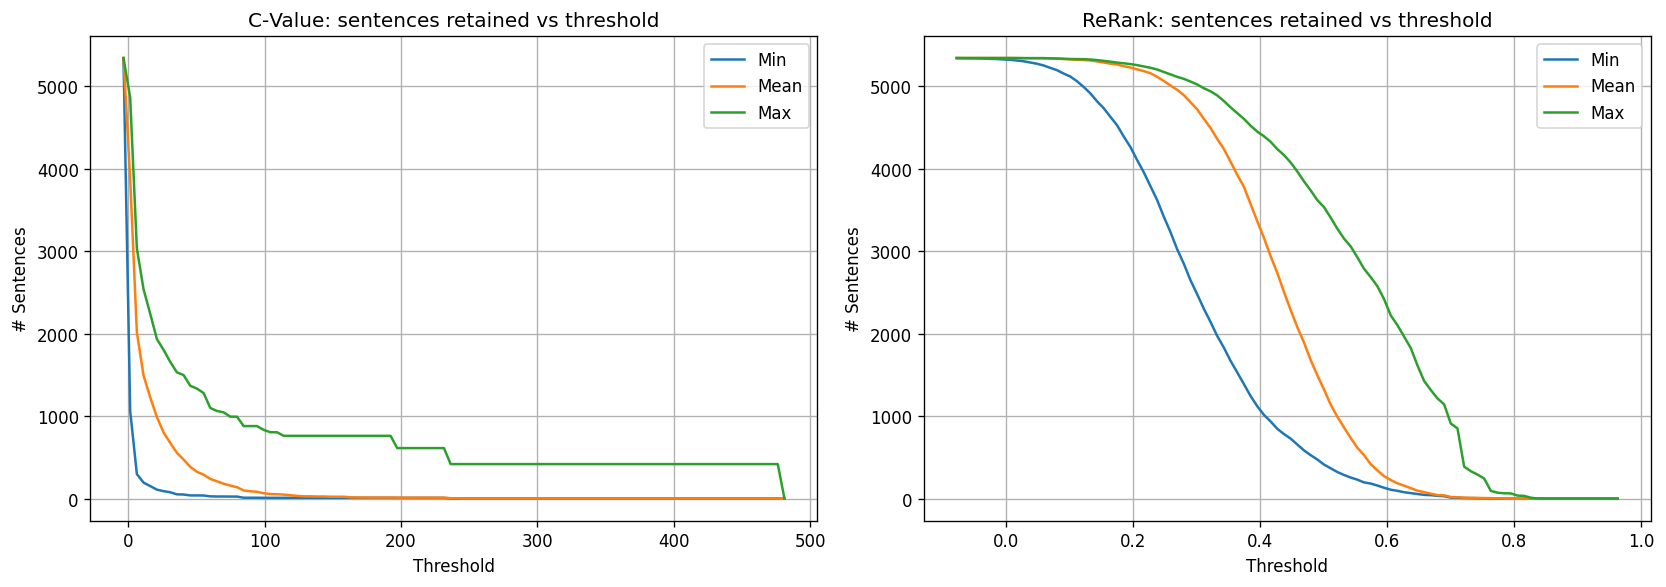

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ---------------------------------------------------------------------------
# This cell assumes term_scores, term_occ, and reranked_scores are already
# defined from your earlier C‑Value and ReRank steps.
# ---------------------------------------------------------------------------

# 1) Bucket all scores that belong to each sentence
bucket_c, bucket_r = defaultdict(list), defaultdict(list)

for term, spans in term_occ.items():
    c_val = term_scores[term]
    r_val = reranked_scores.get(term, None)
    for span in spans:
        s = span.sent  # spaCy sentence object
        bucket_c[s].append(c_val)
        if r_val is not None:
            bucket_r[s].append(r_val)

# 2) Compute per‑sentence min / mean / max
def per_sentence_stats(bucket):
    mins, means, maxs = [], [], []
    for scores in bucket.values():
        mins.append(min(scores))
        means.append(np.mean(scores))
        maxs.append(max(scores))
    return np.array(mins), np.array(means), np.array(maxs)

c_min, c_mean, c_max = per_sentence_stats(bucket_c)
r_min, r_mean, r_max = per_sentence_stats(bucket_r)

stat_arrays = {
    "C-Value": {"min": c_min, "mean": c_mean, "max": c_max},
    "ReRank":  {"min": r_min, "mean": r_mean, "max": r_max}
}

# 3) Threshold ranges (use overall min/max of each method)
thr_c = np.linspace(c_min.min(), c_max.max(), 100)
thr_r = np.linspace(r_min.min(), r_max.max(), 100)

# 4) Compute sentence counts (not rates) above each threshold
cnt_c = {stat: [int((arr > t).sum()) for t in thr_c]
         for stat, arr in stat_arrays["C-Value"].items()}
cnt_r = {stat: [int((arr > t).sum()) for t in thr_r]
         for stat, arr in stat_arrays["ReRank"].items()}

# 5) Plot: #sentences retained vs threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

for stat in ["min", "mean", "max"]:
    ax1.plot(thr_c, cnt_c[stat], label=f"{stat.capitalize()}")
    ax2.plot(thr_r, cnt_r[stat], label=f"{stat.capitalize()}")

ax1.set_title("C‑Value: sentences retained vs threshold")
ax1.set_xlabel("Threshold"); ax1.set_ylabel("# Sentences")
ax1.grid(True); ax1.legend()

ax2.set_title("ReRank: sentences retained vs threshold")
ax2.set_xlabel("Threshold"); ax2.set_ylabel("# Sentences")
ax2.grid(True); ax2.legend()

plt.tight_layout(); plt.show()


In [92]:
bucket_c, bucket_r = defaultdict(list), defaultdict(list)

for term, spans in term_occ.items():
    c_val = term_scores[term]
    r_val = reranked_scores.get(term, None)
    for span in spans:
        s = span.sent  # spaCy sentence object
        bucket_c[s].append(c_val)
        if r_val is not None:
            bucket_r[s].append(r_val)

sent2spans = defaultdict(list)
for term, spans in term_occ.items():
    sc = term_scores.get(term, 0.0)
    sr = reranked_scores.get(term, None)
    for span in spans:
        sent2spans[span.sent].append((span, sc, sr))
sentences = list(doc.sents)

In [96]:
import csv
from pathlib import Path
from collections import defaultdict
from tqdm.auto import tqdm
import pandas as pd
import shutil
import spacy

# Load spaCy model for sentence segmentation
nlp = spacy.load("en_core_web_sm")

# Example: If starting from raw text, convert to sentences using spaCy
# doc = nlp(raw_text)
# sentences = list(doc.sents)

# Ensure `sentences` is a list of spaCy `Span`s and `sent2spans` maps these spans to scored spans

target_dir = Path(OUTPUT_DIR)
target_dir.mkdir(parents=True, exist_ok=True)

# 2) Train TSVs + stats collection
stats = []

for method, agg_map in cvalue_rerank_thresholds.items():
    for agg_name, thr in agg_map.items():
        fname = f"{method}_{agg_name}_{thr}_train_full.tsv"
        out_path = target_dir / fname
        if out_path.exists():
            out_path.unlink()

        b_cnt = i_cnt = o_cnt = sent_cnt = 0

        with out_path.open("w", encoding="utf-8") as fout:
            for sent in tqdm(sentences, desc=f"Writing {fname}", unit="sent"):
                spans = sent2spans.get(sent, [])
                scores = [sc if method == "C-Value" else sr for _, sc, sr in spans]
                if not scores:
                    continue

                if agg_name == "min":
                    metric = min(scores)
                elif agg_name == "mean":
                    metric = sum(scores) / len(scores)
                else:
                    metric = max(scores)

                if metric < thr:
                    continue

                labels = ["O"] * len(sent)
                for span, sc, sr in spans:
                    score = sc if method == "C-Value" else sr
                    if score < thr:
                        continue
                    start = span.start - sent.start
                    end = span.end - sent.start
                    if start < 0 or end <= start:
                        continue
                    labels[start] = "B-TERM"
                    for j in range(start + 1, min(end, len(labels))):
                        labels[j] = "I-TERM"

                for token, lbl in zip(sent, labels):
                    token_text = token.text.strip()
                    label_text = lbl.strip()
                    if token_text and label_text:
                        fout.write(f"{token_text}\t{label_text}\n")
                        if label_text == "O":
                            o_cnt += 1
                        elif label_text == "B-TERM":
                            b_cnt += 1
                        else:
                            i_cnt += 1
                    else:
                        print(f"Skipping malformed line: token='{token_text}' label='{label_text}'")

                fout.write("\n")  # Ensure sentence separation
                sent_cnt += 1

        stats.append({
            'method': method,
            'aggregation_method': agg_name,
            'threshold': thr,
            '#sentences': sent_cnt,
            '#entities': b_cnt + i_cnt,
            '#i': i_cnt,
            '#o': o_cnt,
            '#b': b_cnt
        })
        print(f"Wrote {fname}: sentences={sent_cnt}, B={b_cnt}, I={i_cnt}, O={o_cnt}")

# 3) Display summary table
df = pd.DataFrame(stats,
                  columns=['method', 'aggregation_method', 'threshold',
                           '#sentences', '#entities', '#i', '#o', '#b'])
from IPython.display import display
display(df)


Writing C-Value_min_1.0_train_full.tsv:   0%|          | 0/6732 [00:00<?, ?sent/s]

Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='

Writing C-Value_mean_0.75_train_full.tsv:   0%|          | 0/6732 [00:00<?, ?sent/s]

Streaming output truncated to the last 5000 lines.
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: 

Writing C-Value_max_2_train_full.tsv:   0%|          | 0/6732 [00:00<?, ?sent/s]

Streaming output truncated to the last 5000 lines.
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: 

Writing ReRank_min_0.2_train_full.tsv:   0%|          | 0/6732 [00:00<?, ?sent/s]

Streaming output truncated to the last 5000 lines.
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: 

Writing ReRank_mean_0.275_train_full.tsv:   0%|          | 0/6732 [00:00<?, ?sent/s]

Streaming output truncated to the last 5000 lines.
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: 

Writing ReRank_max_0.3_train_full.tsv:   0%|          | 0/6732 [00:00<?, ?sent/s]

Streaming output truncated to the last 5000 lines.
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: token='' label='O'
Skipping malformed line: 

,method,aggregation_method,threshold,#sentences,#entities,#i,#o,#b
0,C-Value,min,1.000,2326,11977,6873,46743,5104
1,C-Value,mean,0.750,5095,48111,31989,116915,16122
2,C-Value,max,2.000,4581,37251,25949,118526,11302
3,ReRank,min,0.200,4198,34121,22565,88211,11556
4,ReRank,mean,0.275,4928,43402,29207,117376,14195
5,ReRank,max,0.300,5026,42369,28488,122625,13881


In [97]:
out_path

PosixPath('/content/drive/MyDrive/ucu/ner/threshold_datasets/ReRank_max_0.3_train_full.tsv')

In [98]:
!spacy convert -b en_core_web_sm --converter ner /content/drive/MyDrive/ucu/ner/threshold_datasets/ReRank_max_0.3_train_full.tsv .


ℹ Auto-detected token-per-line NER format
ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (5026 documents):
ReRank_max_0.3_train_full.spacy


In [99]:
!cp val_full.tsv /content/drive/MyDrive/ucu/ner/threshold_datasets/val_full.tsv
!cp -r val_full /content/drive/MyDrive/ucu/ner/threshold_datasets/val_full

In [ ]:
from google.colab import runtime
runtime.unassign()